<a href="https://colab.research.google.com/github/Kiedroo12/Finanse/blob/main/Case3ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Instalacje

In [10]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 18.8 MB/s eta 0:00:00


In [11]:
!pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.8/527.8 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.2 MB/s eta 0:00:00


Import

In [15]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import TimeSeriesSplit
import optuna
import numpy as np

In [2]:
TICKER = "AMZN"
START_BUFFER = "2022-01-01"
TEST_START = "2024-01-01"
TEST_END   = "2024-05-06"

In [3]:
df = yf.download(TICKER, start=START_BUFFER, end=pd.to_datetime(TEST_END) + pd.Timedelta(days=1), auto_adjust=True)
df = df.rename(columns=str.lower)
df.index = pd.to_datetime(df.index)
df = df.dropna()

[*********************100%***********************]  1 of 1 completed


In [4]:
print(df.head())
print(df.tail())
print("Zakres:", df.index.min().date(), "->", df.index.max().date(), " | liczba sesji:", len(df))

Price            close        high         low        open    volume
Ticker            amzn        amzn        amzn        amzn      amzn
Date                                                                
2022-01-03  170.404495  170.703506  166.160507  167.550003  63520000
2022-01-04  167.522003  171.399994  166.349503  170.438004  70726000
2022-01-05  164.356995  167.126495  164.356995  166.882996  64302000
2022-01-06  163.253998  164.800003  161.936996  163.450500  51958000
2022-01-07  162.554001  165.243500  162.031006  163.839005  46606000
Price            close        high         low        open    volume
Ticker            amzn        amzn        amzn        amzn      amzn
Date                                                                
2024-04-30  175.000000  182.990005  174.800003  181.089996  94639800
2024-05-01  179.000000  185.149994  176.559998  181.639999  94645100
2024-05-02  184.720001  185.100006  179.910004  180.850006  54303500
2024-05-03  186.210007  187.869995

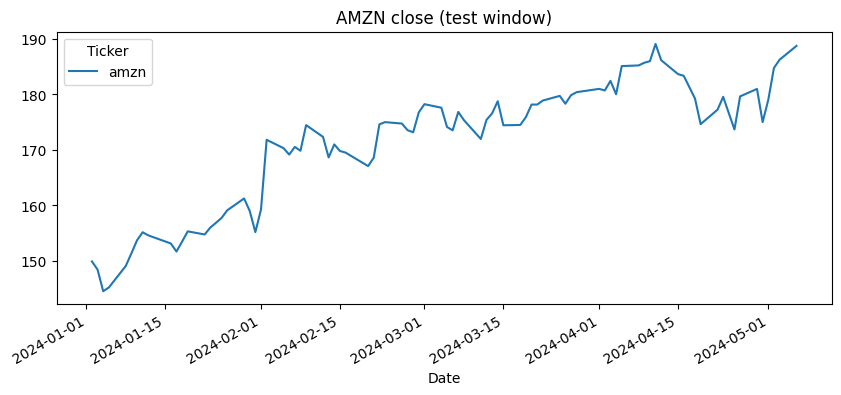

In [5]:
df["close"].loc[TEST_START:TEST_END].plot(figsize=(10,4), title=f"{TICKER} close (test window)")
plt.show()

In [6]:
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

df = df.rename(columns=str.lower)

print(df.columns)
df.head()


Index(['close', 'high', 'low', 'open', 'volume'], dtype='object', name='Price')


Price,close,high,low,open,volume
Date,,,,,
2022-01-03,170.404495,170.703506,166.160507,167.550003,63520000
2022-01-04,167.522003,171.399994,166.349503,170.438004,70726000
2022-01-05,164.356995,167.126495,164.356995,166.882996,64302000
2022-01-06,163.253998,164.800003,161.936996,163.450500,51958000
2022-01-07,162.554001,165.243500,162.031006,163.839005,46606000


In [7]:
feat = df.copy()

#Zwroty
feat["ret_1d"]  = feat["close"].pct_change(1)
feat["ret_5d"]  = feat["close"].pct_change(5)
feat["ret_10d"] = feat["close"].pct_change(10)
feat["ret_20d"] = feat["close"].pct_change(20)

#Zmienność
feat["vol_5d"]  = feat["ret_1d"].rolling(5).std()
feat["vol_10d"] = feat["ret_1d"].rolling(10).std()
feat["vol_20d"] = feat["ret_1d"].rolling(20).std()

#Trend: SMA / EMA
feat["sma_10"] = feat["close"].rolling(10).mean()
feat["sma_20"] = feat["close"].rolling(20).mean()
feat["sma_50"] = feat["close"].rolling(50).mean()

feat["ema_10"] = feat["close"].ewm(span=10, adjust=False).mean()
feat["ema_20"] = feat["close"].ewm(span=20, adjust=False).mean()

#Odchylenie ceny od trendu
feat["close_sma20"] = feat["close"] / feat["sma_20"] - 1
feat["close_sma50"] = feat["close"] / feat["sma_50"] - 1

#RSI(14)
delta = feat["close"].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)

avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()

rs = avg_gain / avg_loss
feat["rsi_14"] = 100 - (100 / (1 + rs))

#MACD
ema12 = feat["close"].ewm(span=12, adjust=False).mean()
ema26 = feat["close"].ewm(span=26, adjust=False).mean()
feat["macd"] = ema12 - ema26
feat["macd_signal"] = feat["macd"].ewm(span=9, adjust=False).mean()
feat["macd_hist"] = feat["macd"] - feat["macd_signal"]

#Stochastic Oscillator
low14  = feat["low"].rolling(14).min()
high14 = feat["high"].rolling(14).max()
feat["stoch_k"] = 100 * (feat["close"] - low14) / (high14 - low14)
feat["stoch_d"] = feat["stoch_k"].rolling(3).mean()

#ATR(14)
hl = feat["high"] - feat["low"]
hc = (feat["high"] - feat["close"].shift()).abs()
lc = (feat["low"] - feat["close"].shift()).abs()

tr = pd.concat([hl, hc, lc], axis=1).max(axis=1)
feat["atr_14"] = tr.rolling(14).mean()

#Wolumen
feat["vol_chg"] = feat["volume"].pct_change(1)
feat["vol_sma20"] = feat["volume"] / feat["volume"].rolling(20).mean() - 1

#Czyszczenie
feat = feat.dropna()

print("Liczba cech:", feat.shape[1])
print("Zakres po dropna:", feat.index.min().date(), "->", feat.index.max().date())
feat.tail()


Liczba cech: 28
Zakres po dropna: 2022-03-15 -> 2024-05-06


Price,close,high,low,open,volume,ret_1d,ret_5d,ret_10d,ret_20d,vol_5d,...,close_sma50,rsi_14,macd,macd_signal,macd_hist,stoch_k,stoch_d,atr_14,vol_chg,vol_sma20
Date,,,,,,,,,,,,,,,,,,,,,
2024-04-30,175.000000,182.990005,174.800003,181.089996,94639800,-0.032935,-0.025287,-0.045385,-0.031490,0.026175,...,-0.017482,36.823109,-0.400866,0.467765,-0.868631,37.014899,52.053994,5.207860,0.750517,1.212885
2024-05-01,179.000000,185.149994,176.559998,181.639999,94645100,0.022857,0.013647,-0.012577,-0.018694,0.027679,...,0.003632,38.162540,-0.349429,0.304326,-0.653755,56.683037,52.042882,5.628573,0.000056,1.059851
2024-05-02,184.720001,185.100006,179.910004,180.850006,54303500,0.031955,0.063626,0.030689,0.026222,0.027608,...,0.033834,48.441985,0.151150,0.273691,-0.122541,82.253008,58.650315,5.780716,-0.426241,0.165774
2024-05-03,186.210007,187.869995,185.419998,186.990005,39172000,0.008066,0.036689,0.066312,0.006160,0.024846,...,0.040818,52.927890,0.660479,0.351048,0.309431,92.297033,77.077693,5.599287,-0.278647,-0.156165
2024-05-06,188.699997,188.750000,184.800003,186.279999,34725300,0.013372,0.042772,0.064718,0.018953,0.024985,...,0.053122,55.794905,1.250631,0.530965,0.719666,99.777071,91.442371,5.697857,-0.113517,-0.248315


In [8]:
HORIZON = 5

data = feat.copy()

data["future_ret_5d"] = data["close"].shift(-HORIZON) / data["close"] - 1

data["target"] = (data["future_ret_5d"] > 0).astype(int)

data = data.dropna()

train_data = data.loc[:TEST_START].copy()
test_data  = data.loc[TEST_START:TEST_END].copy()

FEATURES = [c for c in data.columns if c not in ["target", "future_ret_5d"]]

X_train = train_data[FEATURES]
y_train = train_data["target"]

X_test  = test_data[FEATURES]
y_test  = test_data["target"]

print("TRAIN:", X_train.index.min().date(), "->", X_train.index.max().date(), "|", X_train.shape)
print("TEST :", X_test.index.min().date(),  "->", X_test.index.max().date(),  "|", X_test.shape)
print("\nRozkład targetu (train):")
print(y_train.value_counts(normalize=True))

TRAIN: 2022-03-15 -> 2023-12-29 | (452, 28)
TEST : 2024-01-02 -> 2024-04-29 | (82, 28)

Rozkład targetu (train):
target
1    0.537611
0    0.462389
Name: proportion, dtype: float64


In [13]:
tscv = TimeSeriesSplit(n_splits=5)

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 5),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 10, 100),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "random_state": 42
    }

    model = GradientBoostingClassifier(**params)

    fold_scores = []

    for train_idx, val_idx in tscv.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_tr, y_tr)

        proba = model.predict_proba(X_val)[:, 1]

        future_ret = train_data.iloc[val_idx]["future_ret_5d"]
        pnl_proxy = (proba > 0.5) * future_ret

        fold_scores.append(pnl_proxy.mean())

    return np.mean(fold_scores)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40, show_progress_bar=True)

print("=== BEST PARAMS ===")
print(study.best_params)
print("Best CV trading score:", study.best_value)


[I 2026-01-22 14:09:26,867] A new study created in memory with name: no-name-599e0cb2-e56b-41cf-b566-153749146969


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2026-01-22 14:09:35,205] Trial 0 finished with value: 0.00250187768788543 and parameters: {'n_estimators': 180, 'learning_rate': 0.013220141185400474, 'max_depth': 5, 'min_samples_leaf': 25, 'subsample': 0.6418515776280368}. Best is trial 0 with value: 0.00250187768788543.
[I 2026-01-22 14:09:36,628] Trial 1 finished with value: 0.0023625652209941566 and parameters: {'n_estimators': 74, 'learning_rate': 0.016522004071689907, 'max_depth': 2, 'min_samples_leaf': 69, 'subsample': 0.730443145219385}. Best is trial 0 with value: 0.00250187768788543.
[I 2026-01-22 14:09:37,481] Trial 2 finished with value: 0.0032762428384473857 and parameters: {'n_estimators': 84, 'learning_rate': 0.15935898420963046, 'max_depth': 2, 'min_samples_leaf': 84, 'subsample': 0.9968297983889808}. Best is trial 2 with value: 0.0032762428384473857.
[I 2026-01-22 14:09:41,410] Trial 3 finished with value: 0.0029478370527290325 and parameters: {'n_estimators': 217, 'learning_rate': 0.01682211517256478, 'max_depth':

=== STRATEGIA (ML) ===
Start                         2024-01-02 00:00:00
End                           2024-04-29 00:00:00
Period                           82 days 00:00:00
Start Value                               10000.0
End Value                            10415.353744
Total Return [%]                         4.153537
Benchmark Return [%]                    20.696335
Max Gross Exposure [%]                      100.0
Total Fees Paid                        164.661076
Max Drawdown [%]                         3.956917
Max Drawdown Duration            14 days 00:00:00
Total Trades                                    8
Total Closed Trades                             8
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                                 62.5
Best Trade [%]                           3.769791
Worst Trade [%]                         -3.960874
Avg Winning Trade [%]                    2.659813
Avg Losing Trade [%]       

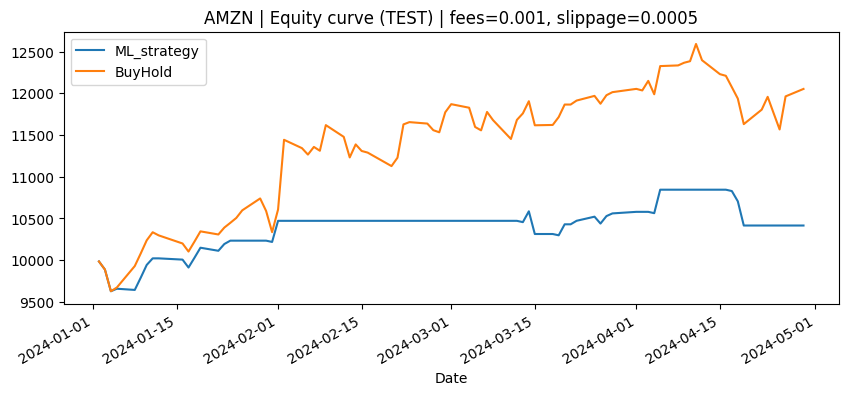

In [16]:
best_params = study.best_params
model = GradientBoostingClassifier(**best_params, random_state=42)
model.fit(X_train, y_train)

proba_test = pd.Series(model.predict_proba(X_test)[:, 1], index=X_test.index, name="p_long")
entries = proba_test > 0.5
exits   = proba_test <= 0.5

close_test = df["close"].loc[X_test.index]

FEE = 0.001
SLIP = 0.0005

pf = vbt.Portfolio.from_signals(
    close=close_test,
    entries=entries,
    exits=exits,
    freq="1D",
    fees=FEE,
    slippage=SLIP,
    init_cash=10_000
)

bh = vbt.Portfolio.from_holding(
    close=close_test,
    freq="1D",
    fees=FEE,
    slippage=SLIP,
    init_cash=10_000
)

print("=== STRATEGIA (ML) ===")
print(pf.stats())
print("\n=== BUY & HOLD ===")
print(bh.stats())

pf.plot().show()
bh.plot().show()

equity = pd.DataFrame({
    "ML_strategy": pf.value(),
    "BuyHold": bh.value()
})
equity.plot(figsize=(10,4), title=f"{TICKER} | Equity curve (TEST) | fees={FEE}, slippage={SLIP}")
plt.show()

Strategia oparta na uczeniu maszynowym osiągnęła dodatnią stopę zwrotu w okresie testowym, jednak ustąpiła strategii buy & hold w warunkach silnego trendu wzrostowego. Jednocześnie model wykazał istotnie lepszą kontrolę ryzyka, ograniczając maksymalne obsunięcie kapitału niemal o połowę względem benchmarku. Wyniki potwierdzają, że strategia ML pełni rolę mechanizmu market timingowego i ochrony kapitału, a nie narzędzia do maksymalizacji zysków w każdej fazie rynku. Jej największa przewaga ujawnia się w okresach podwyższonej zmienności i bessy.

=== ML + SMA200 FILTER ===
Start                         2024-01-02 00:00:00
End                           2024-04-29 00:00:00
Period                           82 days 00:00:00
Start Value                               10000.0
End Value                            10415.353744
Total Return [%]                         4.153537
Benchmark Return [%]                    20.696335
Max Gross Exposure [%]                      100.0
Total Fees Paid                        164.661076
Max Drawdown [%]                         3.956917
Max Drawdown Duration            14 days 00:00:00
Total Trades                                    8
Total Closed Trades                             8
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                                 62.5
Best Trade [%]                           3.769791
Worst Trade [%]                         -3.960874
Avg Winning Trade [%]                    2.659813
Avg Losing Trade [%]   

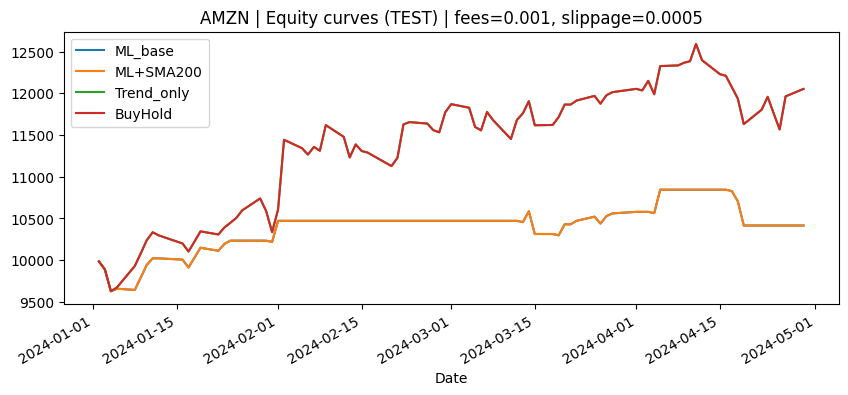

Trend OK days in TEST: 82 z 82


In [17]:
sma200 = df["close"].rolling(200).mean()

trend_ok = (df["close"] > sma200).loc[X_test.index]

entries_trend = entries & trend_ok
exits_trend   = exits | (~trend_ok)

close_test = df["close"].loc[X_test.index]

FEE = 0.001
SLIP = 0.0005

pf_trend = vbt.Portfolio.from_signals(
    close=close_test,
    entries=entries_trend,
    exits=exits_trend,
    freq="1D",
    fees=FEE,
    slippage=SLIP,
    init_cash=10_000
)

bh_trend = vbt.Portfolio.from_signals(
    close=close_test,
    entries=trend_ok,
    exits=~trend_ok,
    freq="1D",
    fees=FEE,
    slippage=SLIP,
    init_cash=10_000
)

print("=== ML + SMA200 FILTER ===")
print(pf_trend.stats())
print("\n=== Trend-only (SMA200) ===")
print(bh_trend.stats())

equity2 = pd.DataFrame({
    "ML_base": pf.value(),
    "ML+SMA200": pf_trend.value(),
    "Trend_only": bh_trend.value(),
    "BuyHold": bh.value()
})
equity2.plot(figsize=(10,4), title=f"{TICKER} | Equity curves (TEST) | fees={FEE}, slippage={SLIP}")
plt.show()

print("Trend OK days in TEST:", int(trend_ok.sum()), "z", len(trend_ok))

W analizowanym okresie testowym kurs akcji pozostawał powyżej średniej kroczącej SMA200, w związku z czym filtr trendu nie ograniczał działania strategii, a wyniki modelu ML z filtrem i bez filtra były tożsame.

=== ML + NEUTRAL ZONE ===
Start                         2024-01-02 00:00:00
End                           2024-04-29 00:00:00
Period                           82 days 00:00:00
Start Value                               10000.0
End Value                            10259.162033
Total Return [%]                          2.59162
Benchmark Return [%]                    20.696335
Max Gross Exposure [%]                      100.0
Total Fees Paid                        162.631257
Max Drawdown [%]                         3.956917
Max Drawdown Duration            14 days 00:00:00
Total Trades                                    8
Total Closed Trades                             8
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                                 62.5
Best Trade [%]                           2.576713
Worst Trade [%]                         -3.960874
Avg Winning Trade [%]                    2.348281
Avg Losing Trade [%]    

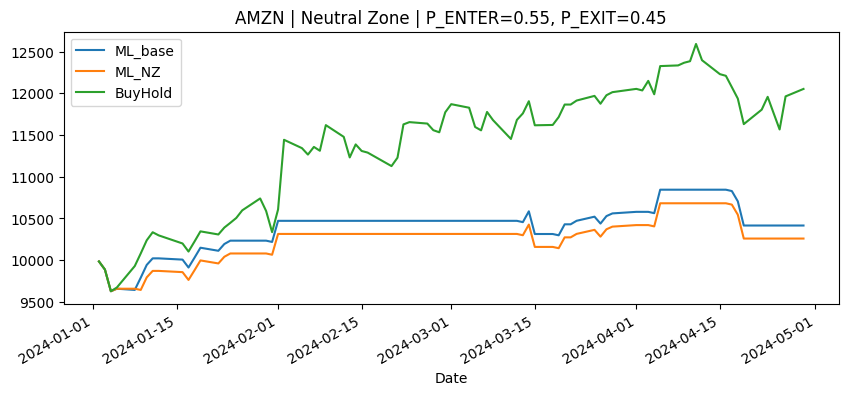

Trades base ML: 8
Trades ML + NZ : 8


In [18]:
P_ENTER = 0.55
P_EXIT  = 0.45

entries_nz = proba_test > P_ENTER
exits_nz   = proba_test < P_EXIT

close_test = df["close"].loc[X_test.index]

FEE = 0.001
SLIP = 0.0005

pf_nz = vbt.Portfolio.from_signals(
    close=close_test,
    entries=entries_nz,
    exits=exits_nz,
    freq="1D",
    fees=FEE,
    slippage=SLIP,
    init_cash=10_000
)

print("=== ML + NEUTRAL ZONE ===")
print(pf_nz.stats())

equity_nz = pd.DataFrame({
    "ML_base": pf.value(),
    "ML_NZ": pf_nz.value(),
    "BuyHold": bh.value()
})

equity_nz.plot(figsize=(10,4), title=f"{TICKER} | Neutral Zone | P_ENTER={P_ENTER}, P_EXIT={P_EXIT}")
plt.show()

print("Trades base ML:", pf.stats()["Total Trades"])
print("Trades ML + NZ :", pf_nz.stats()["Total Trades"])

Wprowadzenie strefy neutralnej dla predykcji modelu nie poprawiło wyników strategii. Analiza liczby transakcji oraz miar ryzyko zwrot wskazuje, że bazowy model generował już relatywnie selektywne sygnały, a dodatkowe filtrowanie prowadziło do utraty części zyskownych transakcji bez redukcji kosztów ani zmienności portfela.

=== ML STRATEGY | 2022 ===
Start                               2022-03-15 00:00:00
End                                 2022-12-30 00:00:00
Period                                202 days 00:00:00
Start Value                                     10000.0
End Value                                   19721.45038
Total Return [%]                              97.214504
Benchmark Return [%]                         -42.999257
Max Gross Exposure [%]                            100.0
Total Fees Paid                              515.745894
Max Drawdown [%]                               7.929896
Max Drawdown Duration                  15 days 00:00:00
Total Trades                                         17
Total Closed Trades                                  16
Total Open Trades                                     1
Open Trade PnL                                19.785354
Win Rate [%]                                      93.75
Best Trade [%]                                16.126992
Worst Trade [%]      

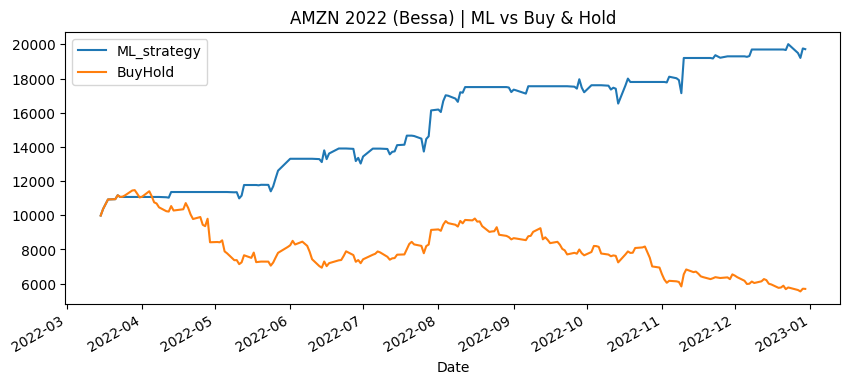

In [19]:
TEST2_START = "2022-01-01"
TEST2_END   = "2022-12-31"

test2022 = data.loc[TEST2_START:TEST2_END].copy()

X_2022 = test2022[FEATURES]
close_2022 = df["close"].loc[X_2022.index]

proba_2022 = pd.Series(
    model.predict_proba(X_2022)[:, 1],
    index=X_2022.index,
    name="p_long"
)

entries_2022 = proba_2022 > 0.5
exits_2022   = proba_2022 <= 0.5

FEE = 0.001
SLIP = 0.0005

pf_ml_2022 = vbt.Portfolio.from_signals(
    close=close_2022,
    entries=entries_2022,
    exits=exits_2022,
    freq="1D",
    fees=FEE,
    slippage=SLIP,
    init_cash=10_000
)

pf_bh_2022 = vbt.Portfolio.from_holding(
    close=close_2022,
    freq="1D",
    fees=FEE,
    slippage=SLIP,
    init_cash=10_000
)

print("=== ML STRATEGY | 2022 ===")
print(pf_ml_2022.stats())

print("\n=== BUY & HOLD | 2022 ===")
print(pf_bh_2022.stats())

equity_2022 = pd.DataFrame({
    "ML_strategy": pf_ml_2022.value(),
    "BuyHold": pf_bh_2022.value()
})

equity_2022.plot(
    figsize=(10,4),
    title="AMZN 2022 (Bessa) | ML vs Buy & Hold"
)
plt.show()

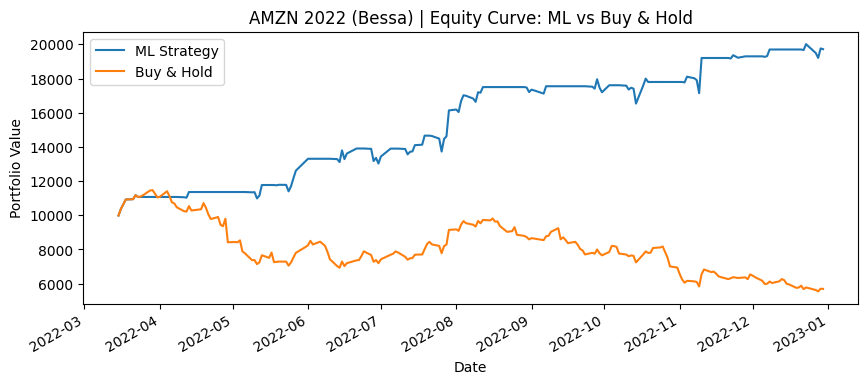

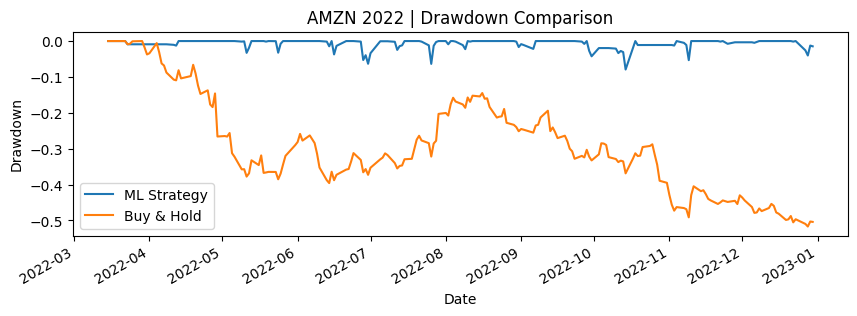

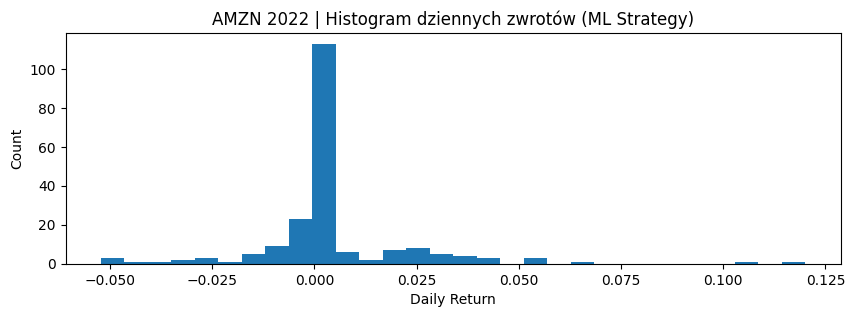

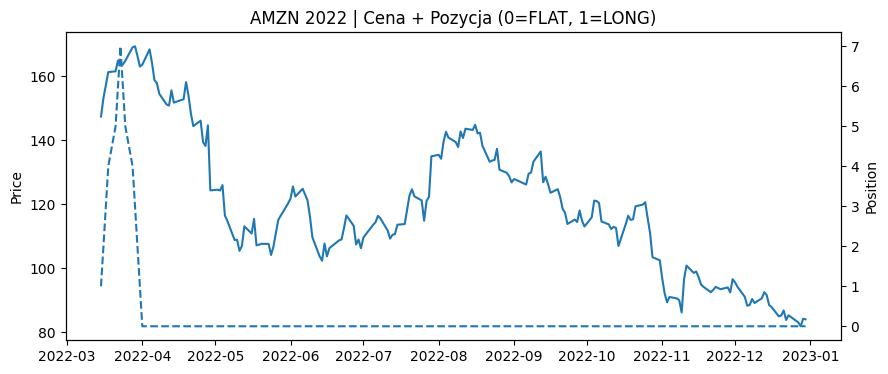

In [20]:
pf_ml_2022.plot().show()

equity_2022 = pd.DataFrame({
    "ML Strategy": pf_ml_2022.value(),
    "Buy & Hold": pf_bh_2022.value()
})

ax = equity_2022.plot(
    figsize=(10,4),
    title="AMZN 2022 (Bessa) | Equity Curve: ML vs Buy & Hold"
)
ax.set_ylabel("Portfolio Value")
plt.show()

dd_2022 = pd.DataFrame({
    "ML Strategy": pf_ml_2022.drawdown(),
    "Buy & Hold": pf_bh_2022.drawdown()
})

ax = dd_2022.plot(
    figsize=(10,3),
    title="AMZN 2022 | Drawdown Comparison"
)
ax.set_ylabel("Drawdown")
plt.show()

rets_2022 = pf_ml_2022.returns().dropna()

plt.figure(figsize=(10,3))
plt.hist(rets_2022, bins=30)
plt.title("AMZN 2022 | Histogram dziennych zwrotów (ML Strategy)")
plt.xlabel("Daily Return")
plt.ylabel("Count")
plt.show()

position_2022 = (
    entries_2022.astype(int)
    .sub(exits_2022.astype(int))
    .cumsum()
    .clip(lower=0)
)

position_2022 = position_2022.reindex(close_2022.index).fillna(0)

fig, ax1 = plt.subplots(figsize=(10,4))

ax1.plot(close_2022.index, close_2022.values)
ax1.set_ylabel("Price")
ax1.set_title("AMZN 2022 | Cena + Pozycja (0=FLAT, 1=LONG)")

ax2 = ax1.twinx()
ax2.plot(position_2022.index, position_2022.values, linestyle="--")
ax2.set_ylabel("Position")

plt.show()


Dodatkowy test w okresie bessy z 2022 roku pokazuje, że model potrafi ograniczać zaangażowanie w rynek podczas silnych spadków cen. Należy jednak pamiętać, że część danych z tego okresu była wykorzystana w procesie uczenia modelu, dlatego uzyskane wyniki nie stanowią w pełni niezależnego testu. Analiza ta służy przede wszystkim pokazaniu, jak strategia zachowuje się w innym otoczeniu rynkowym.

Model został wytrenowany z wykorzystaniem walidacji czasowej oraz optymalizacji hiperparametrów i oceniony przy użyciu realistycznego backtestu uwzględniającego koszty transakcyjne. Wyniki pokazują, że strategia ML nie maksymalizuje zysków w okresach silnej hossy, lecz skutecznie ogranicza ryzyko i obsunięcia kapitału. Największa przewaga modelu ujawnia się w warunkach podwyższonej zmienności i spadków rynkowych, co czyni go użytecznym narzędziem do zarządzania ekspozycją i ochrony kapitału.